In [1]:
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
# clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset, OHTSDataset, OHTSSeverityDataset
import torch.nn as nn
import torch.optim as optim

/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# numberofclasses = glob.glob(f'/mnt/c/Users/PCM/Dropbox/OHTS/train/*')
# lenofclass = {}
# imagesinclass = {}
# for i in range(len(numberofclasses)):
#     imagesinclass[i] = glob.glob(numberofclasses[i] + '/*')
#     lenofclass[i] = len(glob.glob(numberofclasses[i] + '/*'))

In [3]:
data_dir = '/mnt/c/Users/PCM/Dropbox/OHTS'
datalne = {'train':100000, 'val':1000, 'test':10}
image_datasets = {x: OHTSSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="binary_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


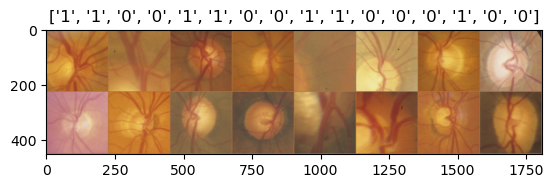

In [4]:
(inputs, _), classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [5]:
siamese50simclr = SiameseNetwork101().to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': siamese50simclr.cnn1.conv1.parameters()},
                        {'params': siamese50simclr.cnn1.layer1.parameters()},
                        {'params': siamese50simclr.cnn1.layer2.parameters()},
                        {'params': siamese50simclr.cnn1.layer3.parameters()},
                        {'params': siamese50simclr.cnn1.layer4.parameters()},
                        {'params': siamese50simclr.cnn1.fc.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
loss_fn = ContrastiveLoss(margin=2.0)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.5)

for param in siamese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in siamese50simclr.cnn1.fc.parameters():
    param.requires_grad = True

load simclr resnet


In [6]:
valaccmax = 0
currloss = 100
for e in range(100):
    training_acc = 0
    val_acc = 0
    training_loss = 0.0
    val_loss = 0.0
    for inputs, labels, _ in dataloaders['train']:
        siamese50simclr.train()
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        output1, output2 = siamese50simclr(inputs[0].to(device), inputs[1].to(device))
        loss = loss_fn(output1, output2, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss += loss.item()
        
    for inputs, labels, _ in dataloaders['val']:
        siamese50simclr.eval()
        labels = labels.to(device)
        with torch.no_grad():
            output1, output2 = siamese50simclr(inputs[0].to(device), inputs[1].to(device))
            loss = loss_fn(output1, output2, labels)
            val_loss += loss.item()

    if(val_loss/dataset_sizes['val'] < currloss):
        currloss = val_loss/dataset_sizes['val']
        today = date.today()
        torch.save(siamese50simclr.state_dict(), f'./pretrained/OHTS-contrastive50-{today}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", "traning loss: ", training_loss / dataset_sizes['train'], "val loss: ", val_loss / dataset_sizes['val'])

E0 With LR 0.01 training acc:  traning loss:  0.05962689439475536 val loss:  0.06292022895812989
E1 With LR 0.005 training acc:  traning loss:  0.051972254756093024 val loss:  0.06488679641485215
E2 With LR 0.005 training acc:  traning loss:  0.04543503720343113 val loss:  0.06741204929351807
E3 With LR 0.0025 training acc:  traning loss:  0.04328317415058613 val loss:  0.0676812549829483
E4 With LR 0.0025 training acc:  traning loss:  0.040258524613529446 val loss:  0.06843731081485749
E5 With LR 0.00125 training acc:  traning loss:  0.03915020848147571 val loss:  0.06685208499431611
E6 With LR 0.00125 training acc:  traning loss:  0.03788953702360392 val loss:  0.06863016134500503
E7 With LR 0.000625 training acc:  traning loss:  0.03725435922428966 val loss:  0.06952042734622955


KeyboardInterrupt: 

In [8]:
torch.save(siamese50simclr.state_dict(), f'./pretrained/OHTS-contrastive50-{today}-besttrain.pt')